# Imports

In [1]:
# General imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import warnings
import logging
import random
import shutil
import os
import gc
import math

# Neural network imports
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.callbacks import EarlyStopping
from transformers import TFAutoModel, AutoTokenizer
from sklearn.model_selection import GroupKFold
!pip install /kaggle/input/autocorrect/autocorrect-2.6.1.tar
from autocorrect import Speller

# Disabling unnecceseray warnings
warnings.simplefilter("ignore")
logging.disable(logging.ERROR)
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Initializing autocorrect and using mixed percision
spell = Speller(lang='en', fast=True)
keras.mixed_precision.set_global_policy("mixed_float16")

2024-07-03 09:04:35.830035: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-03 09:04:35.830142: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-03 09:04:35.953660: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Processing /kaggle/input/autocorrect/autocorrect-2.6.1.tar
  Preparing metadata (setup.py) ... done
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622364 sha256=60a4776886d19357509ab0ee1a7ffdeaeb3fae9ce1c5bbb8fa9141395ee35aea
  Stored in directory: /root/.cache/pip/wheels/db/69/42/0fb0421d2fe70d195a04665edc760cfe5fd341d7bb8d8e0aaa
Successfully built autocorrect


In [2]:
class CFG:
    epochs=9
    pre_trained_model_name="/kaggle/input/deberta-v3-large/deberta_v3_large/"
    final_model_path = f'full_model_scaled-{epochs}.keras'
    learning_rate=0.00015
    weight_decay=1e-4
    warmup_steps=100
    hidden_dropout_prob=0.
    attention_probs_dropout_prob=0.
    n_splits=4
    batch_size=4
    random_seed=42
    max_length=1575
    embeddings_len=1024

In [3]:
def seed_everything(random_seed):
    
    os.environ['PYTHONHASHSEED'] = str(random_seed)
    np.random.seed(random_seed)
    tf.random.set_seed(random_seed)
    random.seed(random_seed)
    keras.utils.set_random_seed(random_seed)
    
seed_everything(random_seed=CFG.random_seed)

In [4]:
def move_to_working_folder(source_path, destination_path):
    shutil.copy(source_path, destination_path)

# Load Data

In [5]:
data_path = '/kaggle/input/commonlit-evaluate-student-summaries/'

# prompts train
train_pro = pd.read_csv(data_path + 'prompts_train.csv')

# summaries train
train_sum = pd.read_csv(data_path + 'summaries_train.csv')
train = train_pro.merge(train_sum , on = "prompt_id")

# prompts test
test_pro = pd.read_csv(data_path + 'prompts_test.csv')

# summaries test
test_sum = pd.read_csv(data_path + 'summaries_test.csv')
test = test_pro.merge(test_sum , on = "prompt_id")
test.head()

,prompt_id,prompt_question,prompt_title,prompt_text,student_id,text
0,abc123,Summarize...,Example Title 1,Heading\nText...,000000ffffff,Example text 1
1,abc123,Summarize...,Example Title 1,Heading\nText...,222222cccccc,Example text 3
2,def789,Summarize...,Example Title 2,Heading\nText...,111111eeeeee,Example text 2
3,def789,Summarize...,Example Title 2,Heading\nText...,333333dddddd,Example text 4


# Data Exploration

### Content and Wording Histograms and Boxplots

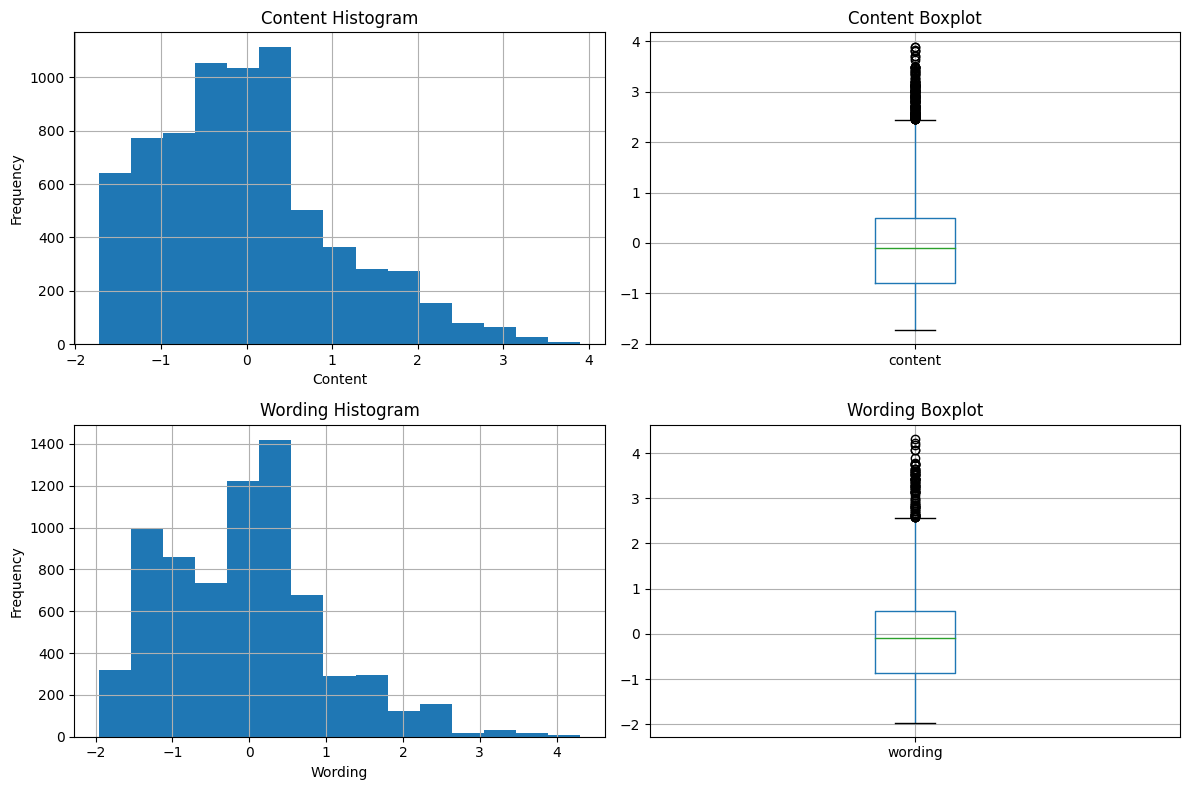

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for i in range (2):
    target = 'Content' if i == 0 else 'Wording'
    for j in range(2):
        if j % 2 == 0:
            train[target.lower()].hist(ax=axes[i][j], bins=15)
            axes[i][j].set_title(f'{target} Histogram')
            axes[i][j].set_xlabel(target)
            axes[i][j].set_ylabel('Frequency')
        else:
            train.boxplot(target.lower(), ax=axes[i][j])
            axes[i][j].set_title(f'{target} Boxplot')
plt.tight_layout()
plt.show()

### Content and Wording Histograms and Boxplots After Log Transformation

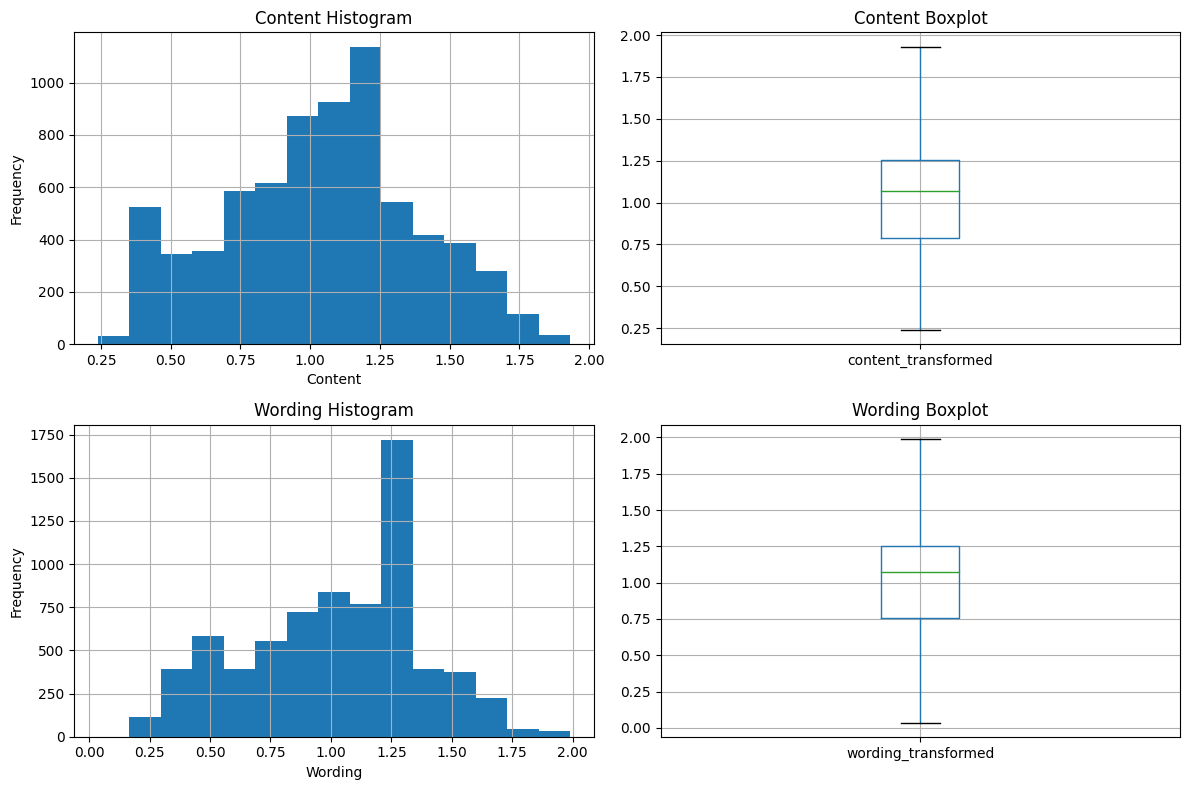

In [7]:
# apply transformations to the content and wording
train['content_transformed'] = (train['content'] + 3).apply(np.log)
train['wording_transformed'] = (train['wording'] + 3).apply(np.log)

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for i in range (2):
    target = 'Content' if i == 0 else 'Wording'
    for j in range(2):
        if j % 2 == 0:
            train[f'{target.lower()}_transformed'].hist(ax=axes[i][j], bins=15)
            axes[i][j].set_title(f'{target} Histogram')
            axes[i][j].set_xlabel(target)
            axes[i][j].set_ylabel('Frequency')
        else:
            train.boxplot(f'{target.lower()}_transformed', ax=axes[i][j])
            axes[i][j].set_title(f'{target} Boxplot')
plt.tight_layout()
plt.show()

### Data Statistics

In [8]:
train['text_length'] = train['text'].apply(len)
train['text_plus_prompt_text_lengths'] = train['text_length'] + train['prompt_text'].apply(len)
train.describe()

,content,wording,content_transformed,wording_transformed,text_length,text_plus_prompt_text_lengths
count,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000
mean,-0.014853,-0.063072,1.033240,1.012884,418.776971,4302.183391
std,1.043569,1.036048,0.350223,0.366330,307.833685,840.802152
min,-1.729859,-1.962614,0.239128,0.036704,114.000000,3459.000000
25%,-0.799545,-0.872720,0.788664,0.754844,216.000000,3646.000000
50%,-0.093814,-0.081769,1.066842,1.070977,320.000000,3871.000000
75%,0.499660,0.503833,1.252666,1.253857,513.000000,5302.000000
max,3.900326,4.310693,1.931569,1.989338,3940.000000,7911.000000


# Preprocessing

In [6]:
prefix1 = "Think through this step by step: "
prefix2 = "Pay attention to the content and wording: "

# This function creates input ids, attention mask and head mask
def preprocess(summary, prompt_question, prompt_text, tokenizer, is_demo=False):
    
    sep = f" {tokenizer.sep_token} " 
    
    if is_demo:
        summary = prefix1 + prompt_question + sep + prefix2 + spell(summary) + sep + prompt_text
        tokenized = tokenizer(summary,
                              add_special_tokens=False,
                              truncation=True,
                              padding='max_length',
                              return_tensors='tf',
                              max_length=CFG.max_length,
                              return_attention_mask=True)
    else:
        summary = prefix1 + prompt_question + sep + prefix2 + summary.apply(spell) + sep + prompt_text
        tokenized = tokenizer.batch_encode_plus(summary.tolist(),
                                                add_special_tokens=False,
                                                truncation=True,
                                                padding='max_length',
                                                return_tensors='tf',
                                                max_length=CFG.max_length,
                                                return_attention_mask=True)
    
    input_ids = tokenized['input_ids']
    attention_mask = tokenized['attention_mask']

    # Create head mask
    head_mask = np.zeros(input_ids.shape)
    for i, summ in enumerate(input_ids.numpy()):
        use_full = False
        for j, token in enumerate(summ):
            if token == tokenizer.sep_token_id:
                use_full = not use_full  
            elif token == tokenizer.pad_token_id:
                break
            head_mask[i][j] = (1. if use_full else 0.) 
    return [input_ids.numpy(), attention_mask.numpy(), head_mask.astype(np.float16)]

# Define Model

### (Optional) Add image of model design diagram

In [7]:
# Creates a model that wraps the pre trained model
@keras.utils.register_keras_serializable()
class PreTrainedModel(keras.Model):
    def __init__(self, model_path, trainable=False, num_layers_to_freeze=0, name=None, **kwargs):
        super().__init__(name=name, **kwargs)
        self.model_path = model_path
        self.trainable = trainable
        self.num_layers_to_freeze = num_layers_to_freeze
        
        # Load model and tokenizer
        self.model = TFAutoModel.from_pretrained(model_path + "model") 
        self.tokenizer = AutoTokenizer.from_pretrained(model_path + "tokenizer")
        
        # Define model configurations
        self.model.trainable = self.trainable
        self.model.config.hidden_dropout_prob = CFG.hidden_dropout_prob
        self.model.config.attention_probs_dropout_prob = CFG.attention_probs_dropout_prob
        
        # Freeze layers if trainable
        if self.trainable:
            self.model.trainable = self.trainable
            if self.trainable:
                for layer in self.model.layers[0].encoder.layer[:self.num_layers_to_freeze]:
                    layer.trainable = False

    # Call the pre trained model and get the all hidden state
    def call(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)
        return output.hidden_states
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'model_path': self.model_path,
            'trainable': self.trainable,
            'num_layers_to_freeze': self.num_layers_to_freeze
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [8]:
# Define layers for head mask step

@keras.utils.register_keras_serializable()
class ExpandDimsLayer(layers.Layer):
    def __init__(self, **kwargs):
        super(ExpandDimsLayer, self).__init__(**kwargs)

    def call(self, inputs):
        return tf.expand_dims(tf.cast(inputs, dtype=tf.float32), axis=-1)

@keras.utils.register_keras_serializable()
class MaskedEmbeddingsLayer(layers.Layer):
    def __init__(self, **kwargs):
        super(MaskedEmbeddingsLayer, self).__init__(**kwargs)

    def call(self, inputs):
        hidden_state, h_mask = inputs
        return tf.multiply(hidden_state, h_mask)

## Define loss function

In [9]:
# The loss function
@keras.utils.register_keras_serializable()
def mcrmse(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float16)
    y_pred = tf.cast(y_pred, tf.float16)
    columnwise_mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=0)
    return tf.reduce_mean(tf.sqrt(columnwise_mse), axis=-1)

In [10]:
@keras.utils.register_keras_serializable()
def build_deberta():
    return PreTrainedModel(CFG.pre_trained_model_name, name="deberta_layer")

In [11]:
def create_model(decay_steps=10000):
    
    # Instances
    pre_trained_model_instance = build_deberta()
    expand_dims_instance = ExpandDimsLayer(name='expand_dims')
    mask_instance = MaskedEmbeddingsLayer(name='masked_embeddings')
    avg_pooling_instance = layers.GlobalAveragePooling1D()
    reshape_instance1 = layers.Reshape((1, -1), name='reshape_layer1')
    reshape_instance2 = layers.Reshape((1, -1), name='reshape_layer2')
    dense_instance = layers.Dense(CFG.embeddings_len, activation='gelu')

    # The NN starts from here
    
    # Input layers
    input_ids = keras.Input(shape=(CFG.max_length,), dtype='int32', name='input_ids')
    attention_mask = keras.Input(shape=(CFG.max_length,), dtype='int32', name='attention_mask')
    head_mask = keras.Input(shape=(CFG.max_length,), dtype='float16', name='head_mask')
    
    # Create embeddings and get all hidden states
    hidden_states = pre_trained_model_instance(input_ids, attention_mask)
    
    # Mask pooling all hidden states of pre-trained model
    pooled_hidden_states = []
    for hidden_state in hidden_states:
        h_mask = expand_dims_instance(head_mask)
        masked_outputs = mask_instance([hidden_state, h_mask])
        avg_pooling_layer = avg_pooling_instance(masked_outputs)
        reshape_layer = reshape_instance1(avg_pooling_layer)
        pooled_hidden_states.append(reshape_layer)
    
    # Concatenate all the hidden states an forward pass through LSTM
    x = layers.Concatenate(axis=1)(pooled_hidden_states)
    x = layers.LSTM(CFG.embeddings_len, return_sequences=False)(x)
    
    # Multi-sample Dropout
    x = layers.Dropout(0.1)(x)
    dropoutList = [reshape_instance2(dense_instance(layers.Dropout((i + 1) * 0.1)(x))) for i in range(5)]
    x = layers.Concatenate(axis=1)(dropoutList)
    x = layers.GlobalAveragePooling1D()(x)
    
    # Final dense layer
    x = layers.Dense(512, activation='linear')(x)
    x = layers.LayerNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Activation(keras.activations.gelu, name='gelu')(x)
    
    output_layer = layers.Dense(2, activation='linear')(x)
    

    # Compile model
    model = keras.Model(inputs=[input_ids, attention_mask, head_mask], outputs=output_layer)
    lr_schedule = tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate=CFG.learning_rate,
                                                            decay_steps=decay_steps,
                                                            warmup_target=CFG.learning_rate,
                                                            warmup_steps=CFG.warmup_steps,
                                                           )
    opt = keras.optimizers.AdamW(learning_rate=lr_schedule, weight_decay=CFG.weight_decay, use_ema=True)
    model.compile(loss=mcrmse, optimizer=opt)
    return model, pre_trained_model_instance

# Train Model

In [20]:
X = train[['text', 'prompt_question', 'prompt_text']]    

# apply transformations to the content and wording
train['content_transformed'] = (train['content'] + 3).apply(np.log)
train['wording_transformed'] = (train['wording'] + 3).apply(np.log)
y = train[['content_transformed', 'wording_transformed']].astype('float16')
    
decay_steps = math.ceil((len(X) / CFG.batch_size) * CFG.epochs) 
model, deberta = create_model(decay_steps=decay_steps)
    
X = preprocess(X['text'], X['prompt_question'], X['prompt_text'], deberta.tokenizer)
    
# Callbacks
ema = keras.callbacks.SwapEMAWeights(swap_on_epoch=True)
ckptcb = keras.callbacks.ModelCheckpoint(
    CFG.final_model_path,
    monitor="loss",
    save_best_only=True,
    mode="min",
)
    
history = model.fit(x=X,
                    y=y.values,
                    epochs=CFG.epochs,
                    batch_size=CFG.batch_size,
                    callbacks=[ema, ckptcb],
                    verbose=1)
    
print('done')

done


# Inference 

In [12]:
def generate_predictions(model, data):
    contents = []
    wordings = []
    ids = []
    predictions = model.predict(x=[data['input_ids'], data['attention_mask'], data['head_mask']],
                                batch_size=CFG.batch_size)

    for idx, output in enumerate(predictions):
        contents.append(output[0])
        wordings.append(output[1])
        ids.append(data['student_id'][idx])

    contents = np.exp(contents) - 3
    wordings = np.exp(wordings) - 3
        
    return ids, contents, wordings

## Inference Baseline Model

In [18]:
# content_scores = np.random.uniform(-1.73, 3.9, len(test))
# wording_scores = np.random.uniform(-1.96, 4.31, len(test))

# submission_df = pd.DataFrame({'student_id': test['student_id'],
#                               'content': content_scores,
#                               'wording': wording_scores})

# submission_df.to_csv("submission.csv", index=False)
# submission_df.head()

## Inference Final Model

In [13]:
model_to_submit_path = '/kaggle/working/' + CFG.final_model_path
move_to_working_folder('/kaggle/input/models/' + CFG.final_model_path, model_to_submit_path)

# Sort by prompt and text lengths
test['length'] = test['text'].apply(len) + test['prompt_text'].apply(len)
test = test.sort_values('length', ascending=True).reset_index(drop=True)


X = test[['text', 'prompt_question', 'prompt_text']]

model = keras.models.load_model(model_to_submit_path)
deberta = build_deberta()
    
X = preprocess(X['text'], X['prompt_question'], X['prompt_text'], deberta.tokenizer)

test_data = {
    'input_ids': X[0],
    'attention_mask': X[1],
    'head_mask': X[2],
    'student_id': test['student_id'],
}

model = keras.models.load_model(model_to_submit_path)
ids, contents, wordings = generate_predictions(model, test_data)
    

submission_df = pd.DataFrame({'student_id': ids,
                              'content': contents,
                              'wording': wordings})

submission_df.to_csv("submission.csv", index=False)
submission_df.head()

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


,student_id,content,wording
0,000000ffffff,-1.012695,-1.548828
1,222222cccccc,-1.025391,-1.536133
2,111111eeeeee,-1.034180,-1.552734
3,333333dddddd,-1.039062,-1.552734


# Demo

### Load Model

In [14]:
model_to_submit_path = '/kaggle/working/' + CFG.final_model_path
move_to_working_folder('/kaggle/input/models/' + CFG.final_model_path, model_to_submit_path)

model = keras.models.load_model(model_to_submit_path)
deberta = build_deberta()

### Sample Random Summary

In [23]:
df = pd.read_excel('/kaggle/input/llm-generate-test/LLM_Generate_Test.xlsx')
random_row = df.sample(n=1)

student_id = random_row.iloc[0,0]
summary = random_row.iloc[0,3]
prompt_question = random_row.iloc[0,2]
prompt_text = random_row.iloc[0,1]

print(f'student_id: {student_id}\n')
print(f'prompt_question: {prompt_question}\n')
print(f'summary: {summary}')

student_id: 12148

prompt_question: Describe the process of photosynthesis and explain its importance in the plant kingdom. 



summary: Photosynthesis is the process through which plants produce oxygen and glucose. It happens in the chloroplasts of the plant cells which have a green pigment called chlorophyll. Sunlight, water, and carbon dioxide are the three critical components that the plant needs for photosynthesis. The first step of the process is absorbing sunlight and converting it into chemical energy. The plant then takes in water through the roots and split it into hydrogen ions and oxygen, which is then released into the atmosphere. Also, carbon dioxide combines with hydrogen ions to form glucose. This process is important to plants as it helps in the production of oxygen, source of energy through glucose production, and in maintaining balance in the atmosphere.


### Score The Summary

In [16]:
# This function gets a students id, summary, prompt question and prompt text
# and scores the summary by content and wording
def run_demo(student_id, summary, prompt_question, prompt_text):
    input_ids, attention_mask, head_mask = preprocess(summary, prompt_question, prompt_text, deberta.tokenizer, is_demo=True)
    
    inputs = {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'head_mask': head_mask,
        'student_id': [student_id],
    }
    content_score, wording_score = (generate_predictions(model, inputs))[1:]
    return content_score[0], wording_score[0]

content_score, wording_score = run_demo(student_id, summary, prompt_question, prompt_text)

print(f'Grade of student: {student_id}')
print(f'Content score: {content_score}')
print(f'Wording score: {wording_score}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
Results of student: 12148
Content score: 1.6796875
Wording score: 0.32421875
